In [1]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from random import random
from scipy.spatial import ConvexHull
from matplotlib import path
import time

% matplotlib inline

Helper functions

In [2]:
def isCollisionFreeVertex(obstacles, xy):
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
#             print 'collision'
            return collFree

    return collFree

In [3]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.001; M = int(l / map_resolution)
    if M <= 2: M = 3
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        p = (1-t[i])*closest_vert + t[i]*xy # calculate configuration
        collFree = isCollisionFreeVertex(obstacles, p) 
        if collFree == False: return False

    return collFree

RRT algorithm

In [10]:
def draw_map():
    # Obstacles. An obstacle is represented as a convex hull of a number of points. 
    # First row is x, second is y (position of vertices)
    w = 0.2
    obstacles = [
                  np.array([[0, 0], [1, 0], [1, 0.1], [0, w]]),
                  np.array([[0, 0], [w, 0.2], [0.1, 2], [0.0, 2.0]]),
                  np.array([[0, 2-w], [1, 2], [1, 2+w], [0, 2+w]]),
                  np.array([[1-w, 0], [1+w, 0], [1+w, 1], [1, 1]]),
                  np.array([[1-w, 2+w], [1+w, 2+w], [1+w, 1.5], [1, 1.5]]),
                  np.array([[0.8, 1], [1+w, 1], [1+w, 1+w], [0.8, 1+w]]),
                  np.array([[0.8, 1.5], [1+w, 1.5], [1+w, 1.5+w], [0.8, 1.5+w]])
                ]

    # Bounds on world
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]


    # Draw obstacles
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch( Polygon(obstacles[k]) )
        
    return obstacles

In [5]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.i     = 0
        self.iPrev = 0

In [6]:
def closestNode(rrt, p):
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0])**2 + (p[1] - node.p[1])**2) )
    distance = np.array(distance)
    
    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

Reached the goal after 6.86 seconds:
Number of iterations passed: 2299 / 5000
RRT length:  237
Constructing the path...
Reached RRT start node


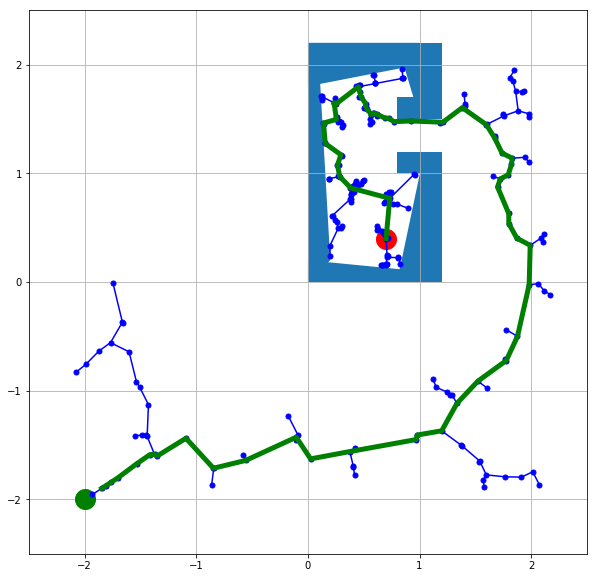

In [33]:
# Initialization
visualize = 1
maxiters  = 5000

obstacles = draw_map()

# Start and goal positions
xy_start = np.array([0.7, 0.4]); plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=20)
xy_goal =  np.array([-2.0, -2.0]);  plt.plot(xy_goal[0], xy_goal[1], 'bo',color='green',markersize=20)

# Initialize RRT. The RRT will be represented as a 2 x N list of points.
# So each column represents a vertex of the tree.
rrt = []
start_node = Node()
start_node.p = xy_start
start_node.i = 0
start_node.iPrev = 0
rrt.append(start_node)
nearGoal = False # This will be set to true if goal has been reached
minDistGoal = 0.1 # Convergence criterion: success when the tree reaches within 0.25 in distance from the goal.
d = 0.20 # Extension parameter: this controls how far the RRT extends in each step.

# RRT algorithm
start_time = time.time()
iters = 0
while not nearGoal and iters < maxiters:
    # Sample point
    rnd = random()
    # With probability 0.05, sample the goal. This promotes movement to the goal.
    if rnd < 0.05:
        xy = xy_goal
    else:
        # Sample (uniformly) from space (with probability 0.95). The space is defined
        # with the bounds world_bounds_x and world_bounds_y defined above.
        # So, the x coordinate should be sampled in the interval
        # world_bounds_x=2.5 and the y coordinate from world_bounds_y=2.5.
        xy = np.array([random()*5-2.5, random()*5-2.5]) # Should be a 2 x 1 vector
    # Check if sample is collision free
    collFree = isCollisionFreeVertex(obstacles, xy)
    # If it's not collision free, continue with loop
    if not collFree:
        iters += 1
        continue

    # If it is collision free, find closest point in existing tree. 
    closest_node = closestNode(rrt, xy)
    
    # Extend tree towards xy from closest_vert. Use the extension parameter
    # d defined above as your step size. In other words, the Euclidean
    # distance between new_vert and closest_vert should be d.
    new_node = Node()
    new_node.p = closest_node.p + d * (xy - closest_node.p)
    new_node.i = len(rrt)
    new_node.iPrev = closest_node.i

    # Check if new vertice is in collision
    collFree = isCollisionFreeEdge(obstacles, closest_node.p, new_node.p)
    # If it's not collision free, continue with loop
    if not collFree:
        iters += 1
        continue
    
    if visualize:
#         plt.plot(xy[0], xy[1], 'ro', color='k')
        plt.plot(new_node.p[0], new_node.p[1], 'bo',color = 'blue', markersize=5) # VERTICES
        plt.plot([closest_node.p[0], new_node.p[0]], [closest_node.p[1], new_node.p[1]], color='blue') # EDGES


    # If it is collision free, add it to tree    
    rrt.append(new_node)

    # Check if we have reached the goal
    if norm(np.array(xy_goal) - np.array(new_node.p)) < minDistGoal:
        end_time = time.time()
        nearGoal = True
        print 'Reached the goal after %.2f seconds:' % (end_time - start_time)

    iters += 1

print 'Number of iterations passed: %d / %d' %(iters, maxiters)
print 'RRT length: ', len(rrt)

# Path construction from RRT:
print 'Constructing the path...'
i = len(rrt) - 1
P = []
while True:
    i = rrt[i].iPrev
    P.append(rrt[i].p)
    if i == 0:
        print 'Reached RRT start node'
        break
P = np.array(P)
plt.plot( P[:,0], P[:,1], color='green', linewidth=5 )